In [1]:
import pandas as pd
import random
import numpy as np
import os
import time

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

In [10]:
def read_data(path):
    
    db = pd.read_csv(path, sep=";")
    
    #delete time
    db = db.drop(['PurchaseDate'], axis=1)
    
    #oneHot cities and group name
    # 1260 городов - delete:)
    db = db.drop(['City'], axis=1)
    
    one_hot_2 = pd.get_dummies(db['GroupTNName'])
    db = db.join(one_hot_2)
    db = db.drop(['GroupTNName'], axis=1)
    
    X = db.values
    # from ['12640,00' '5023,00' '7815,00' ... '655,00' '10466,00' '341,10'] to [12640.0 5023.0 7815.0 ... 655.0 10466.0 341.1]
    X[:, 1] = [float(x[:x.find(',')] + '.' + x[x.find(',') + 1:]) for x in X[:, 1]]
    
    y = [random.choice([1, 0]) for _ in range(X.shape[0])]
    return X, np.asarray(y)


def visual(tree):
    dot_data = "my_tree.dot"
#     names = ['PartnerID', 'SummaAfterDiscount', 'БИЖУТЕРИЯ', 'БИЖУТЕРИЯ_СИ', 'БК', 'ДК', 'ИФ', 'МАРКЕТТОВ', 'ПДК', 'СИ', 'СПЕЦ',
#              'СПЕЦ_БИЖУТЕРИЯ', 'СПЕЦ_СИ', 'ФУТЛЯРЫ', 'ЦБ', 'ЦБ_СИ', 'ЧАСЫ_неювелирные', 'ЧАСЫ_ювелирные']
    export_graphviz(tree, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True)
    os.system("dot -Tpng " + dot_data+ " -o my_tree.png")
    
#     from sklearn.externals.six import StringIO  
#     from IPython.display import Image  
#     from sklearn.tree import export_graphviz
#     import pydotplus
#     dot_data = StringIO()
#     export_graphviz(tree, out_file=dot_data,  
#                     filled=True, rounded=True,
#                     special_characters=True)
#     graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#     Image(graph.create_png())


def find_path(model, X_test):
    
    names = ['PartnerID', 'SummaAfterDiscount', 'БИЖУТЕРИЯ', 'БИЖУТЕРИЯ_СИ', 'БК', 'ДК', 'ИФ', 'МАРКЕТТОВ', 'ПДК', 'СИ', 'СПЕЦ',
             'СПЕЦ_БИЖУТЕРИЯ', 'СПЕЦ_СИ', 'ФУТЛЯРЫ', 'ЦБ', 'ЦБ_СИ', 'ЧАСЫ_неювелирные', 'ЧАСЫ_ювелирные']
    
    n_nodes = model.tree_.node_count
    children_left = model.tree_.children_left
    children_right = model.tree_.children_right
#     feature = [names[i] for i in model.tree_.feature]
    feature = model.tree_.feature
    threshold = model.tree_.threshold
    value = model.tree_.value


    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    count = 0
    for i in range(n_nodes):
        if is_leaves[i]:
            print("%snode=%s leaf node with values = %s." % (node_depth[i] * "\t", i, value[i]))
            count += 1
        else:
            print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                  "node %s."
                  % (node_depth[i] * "\t",
                     i,
                     children_left[i],
                     feature[i],
                     np.round(threshold[i], 2),
                     children_right[i],
                     ))
#         if count == 1:
#             break
    print()


    node_indicator = model.decision_path(X_test)
    leave_id = model.apply(X_test)

    sample_id = 0
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

    print('Rules used to predict sample %s: ' % sample_id)
    for node_id in node_index:
        if leave_id[sample_id] == node_id:
            continue

        if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
            threshold_sign = "<="
        else:
            threshold_sign = ">"

        print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
              % (node_id,
                 sample_id,
                 feature[node_id],
                 X_test[sample_id, feature[node_id]],
                 threshold_sign,
                 np.round(threshold[node_id], 2)))

    # For a group of samples, we have the following common node.
#     sample_ids = [0, 1]
#     common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
#                     len(sample_ids))

#     common_node_id = np.arange(n_nodes)[common_nodes]

#     print("\nThe following samples %s share the node %s in the tree"
#           % (sample_ids, common_node_id))
#     print("It is %s %% of all nodes." % (100 * len(common_node_id) / n_nodes,))
    
    
def run_models(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Linear Classifier 
#     cls = LogisticRegression()
#     cls.fit(X_train, y_train)
#     y_pred = cls.predict(X_test)
#     print ("Accuracy of Logistic Ragression is", accuracy_score(y_test, y_pred) * 100)
    
    
    # Random Forest   
#     rf = RandomForestClassifier(max_depth=10, random_state=0)
#     rf.fit(X_train, y_train)
#     y_pred = rf.predict(X_test)
#     print ("Accuracy of Random Forest is", accuracy_score(y_test, y_pred) * 100)
    
    
    # Decision Tree
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    find_path(tree, X_test)
    visual(tree)
    print ("Accuracy of Decision Tree is", accuracy_score(y_test, y_pred) * 100)

In [11]:
def main():
#     X, y = read_data("purchase_test.csv")
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target # три класса
    run_models(X, y)

start = time.time()
main()
print("Time to do it all =", (time.time() - start) / 60, "minutes")

The binary tree structure has 19 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 2] <= 2.45 else to node 2.
	node=1 leaf node with values = [[40.  0.  0.]].
	node=2 test node: go to node 3 if X[:, 2] <= 4.75 else to node 6.
		node=3 test node: go to node 4 if X[:, 3] <= 1.65 else to node 5.
			node=4 leaf node with values = [[ 0. 36.  0.]].
			node=5 leaf node with values = [[0. 0. 1.]].
		node=6 test node: go to node 7 if X[:, 3] <= 1.75 else to node 14.
			node=7 test node: go to node 8 if X[:, 2] <= 4.95 else to node 9.
				node=8 leaf node with values = [[0. 2. 0.]].
				node=9 test node: go to node 10 if X[:, 3] <= 1.55 else to node 11.
					node=10 leaf node with values = [[0. 0. 3.]].
					node=11 test node: go to node 12 if X[:, 2] <= 5.45 else to node 13.
						node=12 leaf node with values = [[0. 2. 0.]].
						node=13 leaf node with values = [[0. 0. 1.]].
			node=14 test node: go to node 15 if X[:, 2] <= 4.85 else to node 18.
				node=15 te

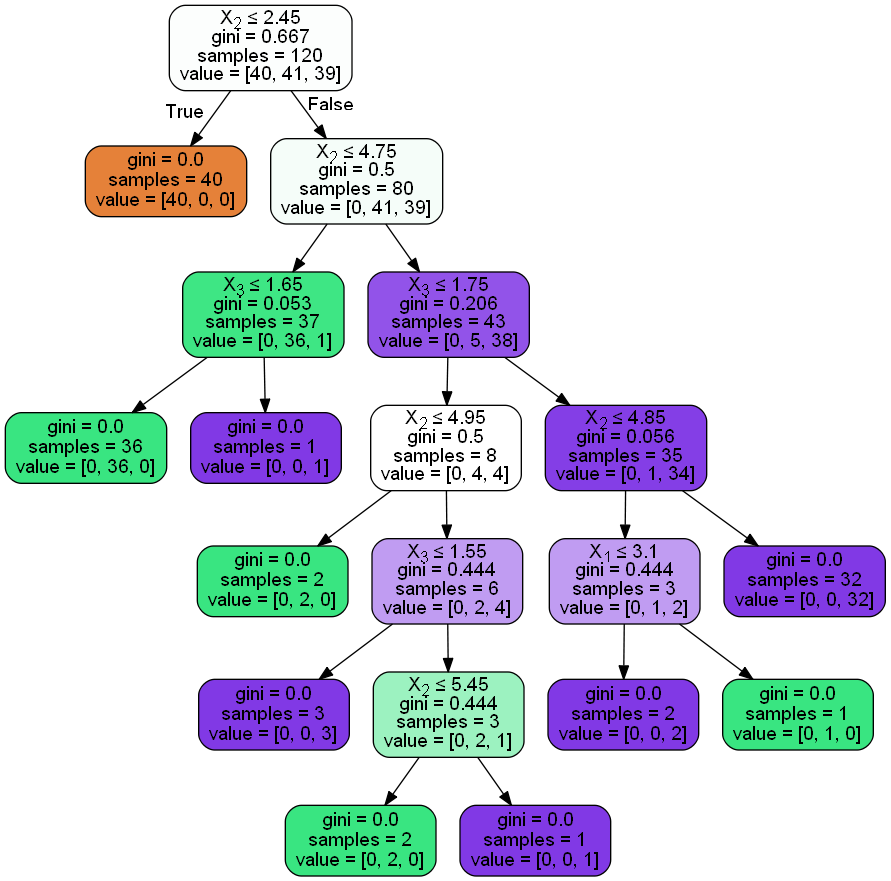

In [16]:
from IPython.display import Image
Image("my_tree.png")